In [1]:
import numpy as np
from skimage.measure import label

def label_baseline(msk1 =None,
                   threshold = 0.5):
    """Transform and label mask so that objects are separated
    
    Keyword arguments:
    msk1 -- mask
    threshold -- labelling threshold (default 0.5)    
    """
    
    labels = (np.copy(msk1)>255*threshold)*1
    labels = label(labels)
    
    return labels

In [2]:
from skimage import io

In [44]:
gt = io.imread('ex1/gt_ln152.png')

In [45]:
from skimage.transform import resize

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
# ii_resized = resize(ii, (300,300))
# ii_resized = ii_resized * 255
# f, ax = plt.subplots(figsize=(10, 9))
# plt.imshow(ii_resized)

In [48]:
gt_lbl = label_baseline(gt, 0.5)

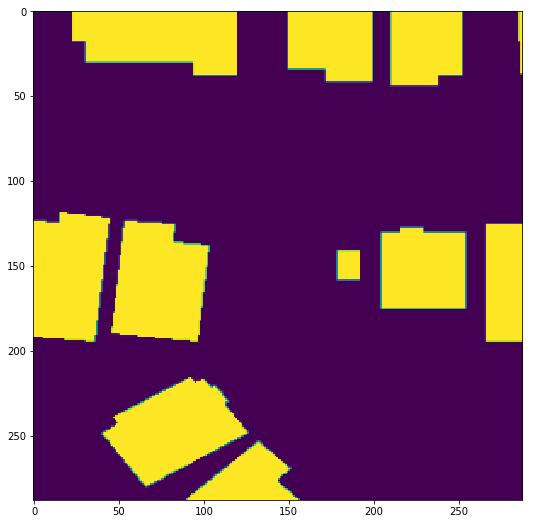

In [50]:
f, ax = plt.subplots(figsize=(10, 9))
plt.imshow(gt)

In [51]:
gt_lbl.shape

(288, 288)

In [52]:
sat = io.imread('ex1/sat_ln152.png')
pred = io.imread('ex1/pred_ln152.png')
pred_lbl = label_baseline(pred, 0.5)

In [53]:
sat.shape

(288, 288, 3)

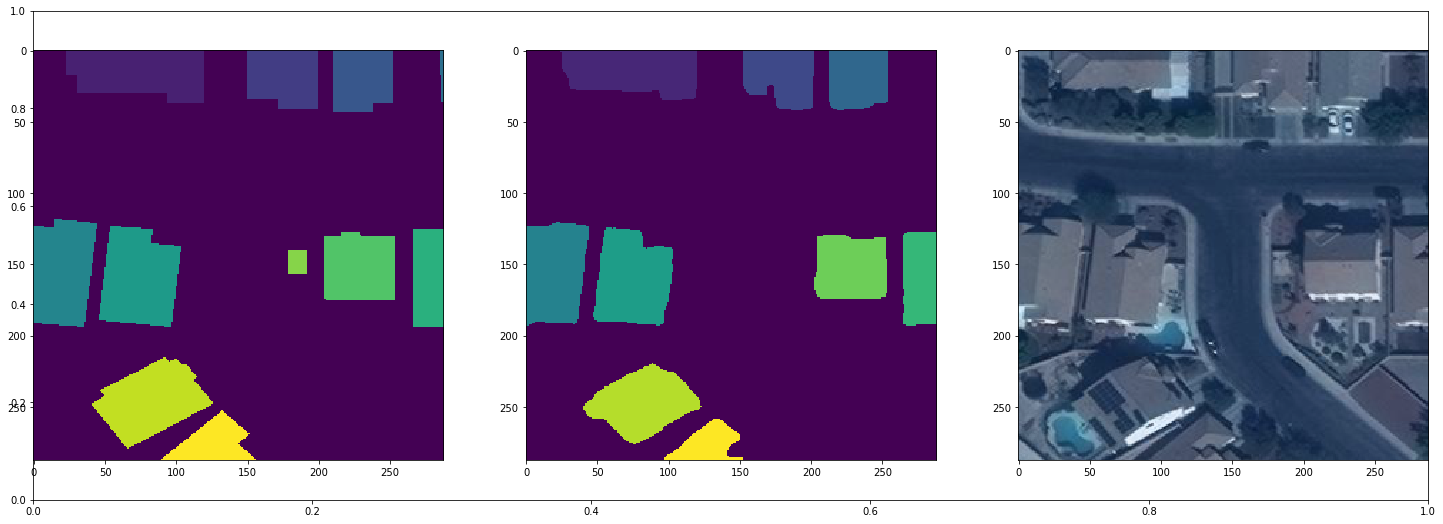

In [54]:
f, ax = plt.subplots(figsize=(25, 9))
f.add_subplot(1, 3, 1)
plt.imshow(gt_lbl)
f.add_subplot(1, 3, 2)
plt.imshow(pred_lbl)
f.add_subplot(1, 3, 3)
plt.imshow(sat)

(-0.5, 287.5, 287.5, -0.5)

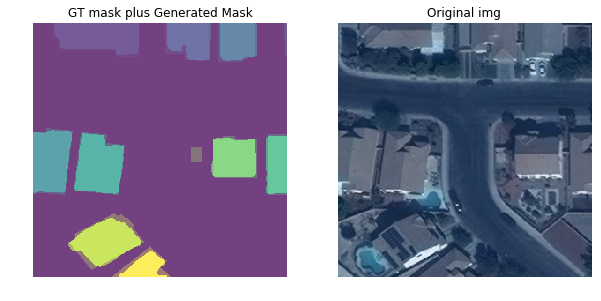

In [55]:
f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(gt_lbl, alpha = 0.5)
ax[0].imshow(pred_lbl, alpha = 0.5)
ax[1].imshow(sat)
ax[0].set_title('GT mask plus Generated Mask')
ax[1].set_title('Original img')
ax[0].axis('off')
ax[1].axis('off')

In [56]:
import os
import itertools

In [57]:
def binarize_mask(mask):
    '''Binarize mask
    
    Keyword arguments:
    mask -- any mask to binarize
    '''
    
    return (mask != 0) * 1

In [58]:
def filter_mask(mask, filter_by = 0):
    '''Filter mask so that everything but specified number is zero
    
    Keyword arguments:
    mask -- any mask to filter
    filter_by -- specified number to leave after filtering (default 0)
    '''
    return (mask == filter_by) * 1

In [117]:
def metrics_single_pair(gtmask, genmask, lbl_treshold = 0.5):
    '''Compute Intersection Over Union and return set of true positives, false positive and false negatives 
    for a pair of ground truth mask and generated mask
    
    Keyword arguments:
    gtmask -- ground truth mask
    genmask -- generated mask
    lbl_threshold -- labeling threshold for mask (default 0.5)
    '''
    gtmask_lbl = label_baseline(gtmask, lbl_treshold)
    genmask_lbl = label_baseline(genmask, lbl_treshold)
    
    max_lbl_gt = np.max(gtmask_lbl)
    max_lbl_gen = np.max(genmask_lbl)
    
    combs = itertools.product(np.arange(0, max_lbl_gt, 1), np.arange(0, max_lbl_gen, 1))
    
    ious = []
    dious = {}
    TPs = 0
    FPs = 0
    FNs = 0
    
    for a in np.arange(1, max_lbl_gt + 1, 1):
        iou_a = 0
        for b in np.arange(1, max_lbl_gen + 1, 1):
            gt_filtered = binarize_mask(filter_mask(gtmask_lbl, a))
            gen_filtered = binarize_mask(filter_mask(genmask_lbl, b))

            union = np.sum(binarize_mask(gt_filtered + gen_filtered))
            intersect = np.sum(gt_filtered * gen_filtered)

            iou = 0
            if union > 0:
                iou = intersect / union
                
            if iou > iou_a: 
                iou_a = iou
                
        ious.append(iou_a)
        dious[a] = iou_a
    TPs = np.sum([x >= 0.5 for x in ious])
    FNs = np.sum([x < 0.5 for x in ious])
    if max_lbl_gen > max_lbl_gt:
        FPs = max_lbl_gen - max_lbl_gt # false positives
    return TPs, FPs, FNs, dious

In [118]:
def compute_precision_recall(TPs, FPs, FNs):
    '''Compute Precision-Recall for a set of true positives, false positives and false negatives for a single pair of masks
    
    Keyword arguments:
    TPs -- number of true positives
    FPs -- number of false positives
    FNs -- number of false negatives
    '''
#     print('TPs: {:.4f}, FPs: {:.4f}, FNs: {:.4f}'.format(TPs, FPs, FNs))
    precision = TPs/(TPs + FPs)
    recall = TPs/(TPs + FNs)
    
    return precision, recall

In [119]:
def compute_label_center(mask, label = 0):
    '''Compute lebel center in order to mark it on a visualization
    
    Keyword arguments:
    mask -- some mask
    label -- some label for filtering (default 0)
    '''
    
    itemindex = np.where(mask == label)
    centerx = int(np.round((np.max(itemindex[1]) + np.min(itemindex[1])) / 2, 0))
    centery = int(np.round((np.max(itemindex[0]) + np.min(itemindex[0])) / 2, 0))
    return centerx, centery

In [135]:
def mix_vis_masks(gtmask, 
                  genmask, 
                  orig, 
                  lbl_treshold = 0.5, 
                  save_path = '', 
                  save_title = 'example.png'):
    '''Visualize and save ground truth and generated masks 
    mixed together to compare alongside with original image.
    
    Keyword arguments:
    gtmask -- ground truth mask
    genmask -- generated mask
    orig -- original image
    lbl_threshold -- labeling threshold for mask (default 0.5)'''
    
    TPs, FPs, FNs, dious = metrics_single_pair(gtmask, genmask, lbl_treshold)
    
    precision, recall = compute_precision_recall(TPs, FPs, FNs)
    
    gtmask_lbl = label_baseline(gtmask, lbl_treshold)
    genmask_lbl = label_baseline(genmask, lbl_treshold)
    
    f, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(gtmask_lbl, alpha = 0.5)
    ax[0].imshow(genmask_lbl, alpha = 0.5)
    
    for key, value in dious.items():
        centerx, centery = compute_label_center(gtmask_lbl, key)
        ax[0].text(centerx, centery, '{:.2f}'.format(value), weight = 'bold', color = 'black', size = 14)
    
    ax[1].imshow(orig)
    ax[0].set_title('Pr: {:.2f}, Re: {:.2f}, FPs: {:.2f}, TPs: {:.2f}, FNs: {:.2f}'.format(precision, recall, TPs, FPs, FNs))
    ax[1].set_title('Original Img')
    ax[0].axis('off')
    ax[1].axis('off')
    
    plt.savefig(os.path.join(save_path, save_title))   
    

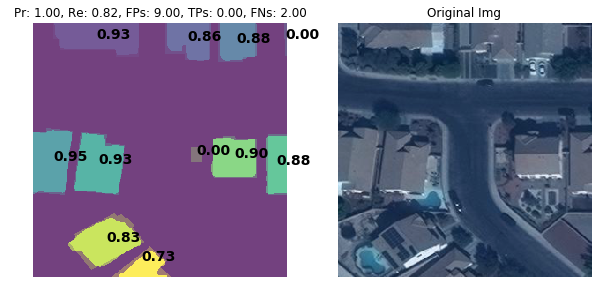

In [136]:
mix_vis_masks(gt, 
              pred, 
              sat, 
              lbl_treshold = 0.5, 
              save_path = '', 
              save_title = 'example.png')